In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms

In [11]:
import sys
sys.path.append("./../../")

from modules.dvae.model import DVAE
from modules.dvae.funcs import ng_quantize
from modules.common_blocks import TrDecoderBlock
from datasets.mnist_loader import MNISTData
from notebooks.utils import show

In [12]:
def subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1).float()
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [13]:
class Config:
    DEVICE                      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_channels                = 1
    vocab_size                  = 32
    
    hidden_height               = 7
    hidden_width                = 7

    num_blocks                  = 8
    n_attn_heads                = 8
    hidden_dim                  = 256
    dropout_prob                = 0.1

    dvae_num_x2upsamples        = 2
    dvae_num_resids_downsample  = 3
    dvae_num_resids_bottleneck  = 4
    dvae_hidden_dim             = 256

    mnist_type                  = "classic"
    root_img_path               = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"
    
    load_dvae_path              = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dvae_vocab32_mnist/"
    dvae_model_name             = "dvae_vocab32_mnist"
    
    model_path                  = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dtr_ugen_v2_mnist/"
    model_name                  = "dtr_ugen_v2_mnist"
    
    NUM_EPOCHS                  = 30
    BATCH_SIZE                  = 512
    LR                          = 0.001
    LR_gamma                    = 0.1
    step_LR_milestones          = [5, 15, 25]


CONFIG = Config()

In [14]:
data_source = MNISTData(
    img_type=CONFIG.mnist_type,
    root_path=CONFIG.root_img_path,
    batch_size=CONFIG.BATCH_SIZE)
train_loader = data_source.get_train_loader()

In [15]:
class Generator(nn.Module):
    def __init__(self,
                 hidden_width,
                 hidden_height,
                 embedding_dim,
                 num_blocks,
                 hidden_dim,
                 n_attn_heads,
                 dropout_prob):
        super(Generator, self).__init__()

        self.hidden_width = hidden_width
        self.hidden_height = hidden_height
        self.embedding_dim = embedding_dim
        
        self.proj_in = nn.Linear(embedding_dim, embedding_dim)
        self.proj_out = nn.Linear(embedding_dim, embedding_dim)
        
        self.pe_col = nn.Parameter(torch.randn(hidden_width, 1, embedding_dim))
        self.pe_row = nn.Parameter(torch.randn(hidden_height, 1, embedding_dim))
        
        self.tr_dec_blocks = nn.ModuleList([
            TrDecoderBlock(
                n_features=embedding_dim,
                n_attn_heads=n_attn_heads,
                n_hidden=hidden_dim,
                dropout_prob=dropout_prob)
            for _ in range(num_blocks)
        ])
        
    def forward(self, x, noise):
        seq_len, batch, emb = x.size()
        mask = subsequent_mask(seq_len).to(x.device)
        x = self.proj_in(x)
        
        pe_column = self.pe_col.repeat(self.hidden_width, 1, 1)
        pe_row = self.pe_row.repeat_interleave(self.hidden_height, dim=0)
        x = x + pe_column + pe_row
        
        for i, block in enumerate(self.tr_dec_blocks):
            x, _, _ = block(x, noise, attn_mask=mask)
        
        x = self.proj_out(x)
        return x
    
    def save_model(self, root_path, model_name):
        if not os.path.exists(root_path):
            os.makedirs(root_path)
        path = os.path.join(root_path, model_name + ".pth")
        torch.save(self.state_dict(), path)
    
    def load_model(self, root_path, model_name, map_location=torch.device('cpu')):
        path = os.path.join(root_path, model_name + ".pth")
        self.load_state_dict(torch.load(path, map_location=map_location))

In [16]:
dvae = DVAE(
    in_channels=CONFIG.img_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.dvae_num_x2upsamples,
    num_resids_downsample=CONFIG.dvae_num_resids_downsample,
    num_resids_bottleneck=CONFIG.dvae_num_resids_bottleneck,
    hidden_dim=CONFIG.dvae_hidden_dim)

G = Generator(
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob)

optimizer = optim.Adam(G.parameters(), lr=CONFIG.LR)

lr_scheduler = MultiStepLR(optimizer, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)

In [17]:
dvae.load_model(
    root_path=CONFIG.load_dvae_path,
    model_name=CONFIG.dvae_model_name)

dvae.eval()
G.train()

dvae.to(CONFIG.DEVICE)
G.to(CONFIG.DEVICE)

pass

In [18]:
print("Device in use: {}".format(CONFIG.DEVICE))

criteriation = nn.CrossEntropyLoss()

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for img, label in train_loader:
        img = img.to(CONFIG.DEVICE)
        
        with torch.no_grad():
            latent = dvae.ng_q_encode(img)
            b, emb, h, w = latent.size()
            x = latent.view(b, emb, -1).permute(2, 0, 1)
            
        noise = torch.randn(1, b, emb, device=CONFIG.DEVICE)
        
        start_vector = torch.zeros(1, b, emb, device=x.device)
        x_strat_seq = torch.cat([start_vector, x[:-1,:,:]], dim=0)
        x_end_seq = x
        
        output = G(x_strat_seq, noise)
        
        labels_pred = output.view(-1, emb)
        lables_true = x_end_seq.argmax(dim=2).view(-1)
        
        loss = criteriation(labels_pred, lables_true)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iteration += 1

        if iteration % 55 == 0:
            print("Epoch: {} Iter: {} Loss: {}".format(epoch, iteration, round(loss.item(), 5)))
    
    #lr_scheduler.step()

#G.save_model(CONFIG.model_path, CONFIG.model_name)

Device in use: cuda
Epoch: 0 Iter: 55 Loss: 2.24382
Epoch: 0 Iter: 110 Loss: 2.11685
Epoch: 1 Iter: 165 Loss: 2.02058
Epoch: 1 Iter: 220 Loss: 1.92579
Epoch: 2 Iter: 275 Loss: 1.87669
Epoch: 2 Iter: 330 Loss: 1.78908
Epoch: 3 Iter: 385 Loss: 1.7106
Epoch: 3 Iter: 440 Loss: 1.63198
Epoch: 4 Iter: 495 Loss: 1.60979
Epoch: 4 Iter: 550 Loss: 1.55508
Epoch: 5 Iter: 605 Loss: 1.52059
Epoch: 5 Iter: 660 Loss: 1.51239
Epoch: 6 Iter: 715 Loss: 1.4841
Epoch: 6 Iter: 770 Loss: 1.47035
Epoch: 6 Iter: 825 Loss: 1.45532
Epoch: 7 Iter: 880 Loss: 1.45034
Epoch: 7 Iter: 935 Loss: 1.43801
Epoch: 8 Iter: 990 Loss: 1.41841
Epoch: 8 Iter: 1045 Loss: 1.40432
Epoch: 9 Iter: 1100 Loss: 1.40048
Epoch: 9 Iter: 1155 Loss: 1.41067
Epoch: 10 Iter: 1210 Loss: 1.39303
Epoch: 10 Iter: 1265 Loss: 1.38382
Epoch: 11 Iter: 1320 Loss: 1.39925
Epoch: 11 Iter: 1375 Loss: 1.35945
Epoch: 12 Iter: 1430 Loss: 1.34689
Epoch: 12 Iter: 1485 Loss: 1.37497
Epoch: 13 Iter: 1540 Loss: 1.3473
Epoch: 13 Iter: 1595 Loss: 1.34929
Epoch: 1

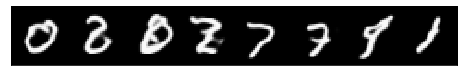

In [19]:
hidden_width = CONFIG.hidden_width
hidden_height = CONFIG.hidden_height
seq_len = hidden_width * hidden_height
embedding_dim = CONFIG.vocab_size
batch_size = 8

samples = torch.zeros(seq_len + 1, batch_size, embedding_dim).to(CONFIG.DEVICE)

with torch.no_grad():
    noise = torch.randn(1, batch_size, embedding_dim, device=CONFIG.DEVICE)
    for i in range(seq_len):
        out = G(samples[:-1,:,:], noise)
        
        probs = F.softmax(out[i, :, :], dim=-1)

        index = torch.multinomial(probs, num_samples=1)

        one_hot_sample = torch.zeros(batch_size, embedding_dim).to(CONFIG.DEVICE)
        one_hot_sample = torch.scatter(one_hot_sample, 1, index, 1.0)
        
        samples[i+1, :, :] = one_hot_sample

latent_x = samples[1:, :, :].view(hidden_height, hidden_width, batch_size, embedding_dim).permute(2, 3, 0, 1)

with torch.no_grad():
    gen_img = dvae.decode(latent_x)

img_grid = make_grid(gen_img.detach().cpu())
show(img_grid)

In [ ]:
hidden_width = CONFIG.hidden_width
hidden_height = CONFIG.hidden_height
seq_len = hidden_width * hidden_height
embedding_dim = CONFIG.vocab_size
batch_size = 8

samples = torch.zeros(seq_len + 1, batch_size, embedding_dim).to(CONFIG.DEVICE)

with torch.no_grad():
    noise = torch.randn(1, current_batch_dim, CONFIG.vocab_size, device=CONFIG.DEVICE)
    for i in range(seq_len):
        out = G(samples[:-1,:,:], noise)
        one_hot_sample = ng_quantize(out)
        samples[i+1, :, :] = one_hot_sample[i,:,:]

latent_x = samples[1:, :, :].view(hidden_height, hidden_width, batch_size, embedding_dim).permute(2, 3, 0, 1)

with torch.no_grad():
    gen_img = dvae.decode(latent_x)

img_grid = make_grid(gen_img.detach().cpu())
show(img_grid)

In [27]:
# def generate_from_part(latent,
#                        dvae,
#                        hidden_height=7,
#                        hidden_width=7,
#                        start_seq_len=25,
#                        batch_size=8,
#                        embedding_dim=32,
#                        device=torch.device("cuda")):
#     seq_len = hidden_height * hidden_width

#     b, emb, h, w = latent.size()
#     x = latent.view(b, emb, -1).permute(2, 0, 1)

#     latent_x = torch.empty(seq_len, batch_size, embedding_dim, device=device)

#     latent_x[:start_seq_len, :, :] = x[:start_seq_len, :batch_size, :]
    
#     for i in range(seq_len - start_seq_len):
#         with torch.no_grad():
#             outputs = G(latent_x[:start_seq_len + i])
#         outputs_onehot = ng_quantize(outputs[[-1], :, :], dim=2)
#         latent_x[start_seq_len + i] = outputs_onehot

#     latent_x = latent_x.view(hidden_height, hidden_width, batch_size, embedding_dim).permute(2, 3, 0, 1)
    
#     with torch.no_grad():
#         gen_img = dvae.ng_q_decode(latent_x)

#     img_grid = make_grid(gen_img.detach().cpu())
#     show(img_grid)



# print("Device in use: {}".format(CONFIG.DEVICE))

# criteriation = nn.CrossEntropyLoss()

# iteration = 0
# for epoch in range(CONFIG.NUM_EPOCHS):
#     for img, label in train_loader:
#         img = img.to(CONFIG.DEVICE)

#         with torch.no_grad():
#             latent = dvae.ng_q_encode(img)

#         b, emb, h, w = latent.size()
#         x = latent.view(b, emb, -1).permute(2, 0, 1)
        
#         x_strat_seq = x[:-1, :, :]
#         x_end_seq = x[1:, :, :]
        
#         output = G(x_strat_seq)
        
#         labels_pred = output.view(-1, emb)
#         lables_true = x_end_seq.argmax(dim=2).view(-1)
        
#         loss = criteriation(labels_pred, lables_true)
        
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         iteration += 1

#         if iteration % 55 == 0:
#             print("Epoch: {} Iter: {} Loss: {}".format(epoch, iteration, round(loss.item(), 5)))
    
#     if (epoch + 1) % 5 == 0:
#         generate_from_part(
#             latent=latent,
#             dvae=dvae,
#             embedding_dim=CONFIG.vocab_size,
#             hidden_height=CONFIG.hidden_height,
#             hidden_width=CONFIG.hidden_width,
#             start_seq_len=25,
#             batch_size=8,
#             device=CONFIG.DEVICE
#         )